In [61]:
import importlib
import Data_Prep
importlib.reload(Data_Prep)
from Data_Prep import Data_Prep, Player_IO
import Prep_Map
importlib.reload(Prep_Map)
import Output_Map
importlib.reload(Output_Map)
import Player_Dataset
importlib.reload(Player_Dataset)
from Player_Dataset import Player_Dataset, Create_Test_Train_Datasets
import Player_Model
importlib.reload(Player_Model)
from Player_Model import RNN_Model
import Model_Train
importlib.reload(Model_Train)
from Model_Train import trainAndGraph
from Constants import device, DEFAULT_NUM_LAYERS_HITTER, DEFAULT_HIDDEN_SIZE_HITTER

In [62]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [63]:
batch_size = 800
num_epochs = 300

Experimental Pretraining

In [64]:
num_layers = 3
hidden_size = 20

In [65]:
data_prep = Data_Prep(Prep_Map.experimental_prep_map, Output_Map.base_output_map)
#hitter_io_list = data_prep.Generate_IO_Hitters("WHERE lastMLBSeason<? AND signingYear<? AND isHitter=? AND (mlbId=? OR mlbId=? OR mlbId=? OR mlbId=? OR mlbId=?)", (2025,2015,1, 593934, 608336, 448801,519317,656941), use_cutoff=True)
hitter_io_list = data_prep.Generate_IO_Hitters("WHERE lastMLBSeason<? AND signingYear<? AND isHitter=?", (2025,2015,1), use_cutoff=True)
train_dataset, test_dataset = Create_Test_Train_Datasets(hitter_io_list, 0.25, 0)

Epoch [1/300], Train Loss: 23.7915, Test Loss: 8.3313
Epoch [11/300], Train Loss: 5.2727, Test Loss: 5.1869
Epoch [21/300], Train Loss: 4.9847, Test Loss: 5.3281
Epoch [31/300], Train Loss: 4.9759, Test Loss: 4.8654
Epoch [41/300], Train Loss: 4.6771, Test Loss: 4.6768
Epoch [51/300], Train Loss: 4.5416, Test Loss: 4.7301
Epoch [61/300], Train Loss: 4.5644, Test Loss: 4.6474
Epoch [71/300], Train Loss: 4.4064, Test Loss: 4.5410
Epoch [81/300], Train Loss: 4.5132, Test Loss: 4.5006
Epoch [91/300], Train Loss: 4.4015, Test Loss: 4.5216
Epoch [101/300], Train Loss: 4.3342, Test Loss: 4.5289
Epoch [111/300], Train Loss: 4.2424, Test Loss: 4.3941
Epoch [121/300], Train Loss: 4.2208, Test Loss: 4.4244
Epoch [131/300], Train Loss: 4.1484, Test Loss: 4.3521
Epoch [141/300], Train Loss: 4.1708, Test Loss: 4.3414
Epoch [151/300], Train Loss: 4.2759, Test Loss: 4.4538
Epoch [161/300], Train Loss: 4.2108, Test Loss: 4.2917
Epoch [171/300], Train Loss: 4.1631, Test Loss: 4.2292
Epoch [181/300], Tra

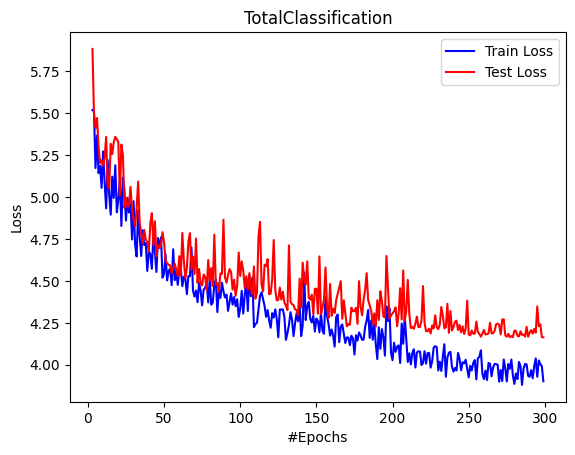

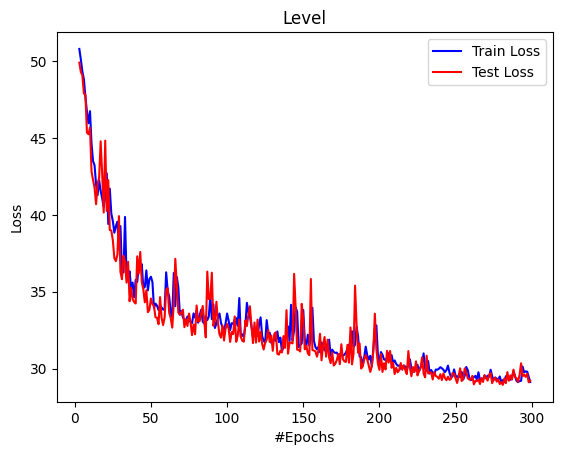

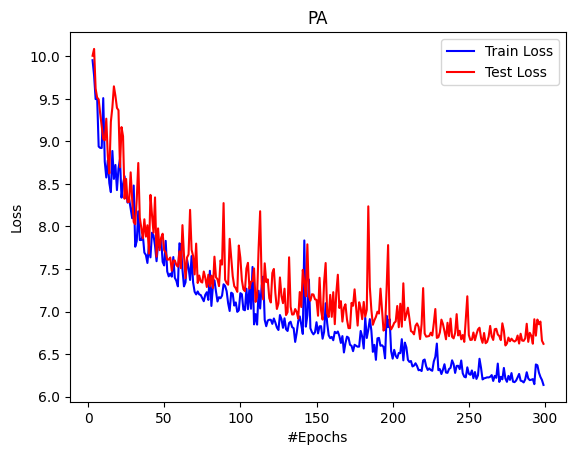

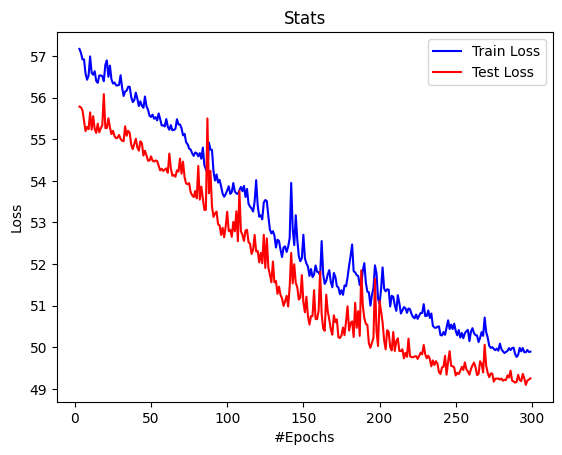

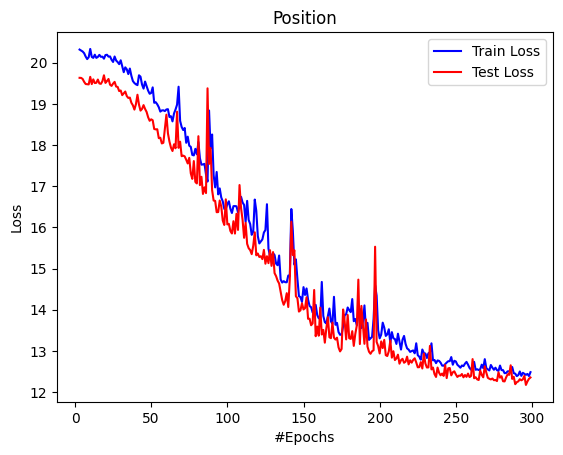

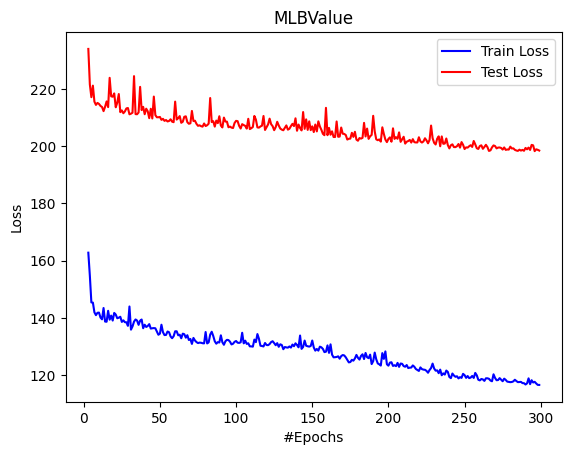

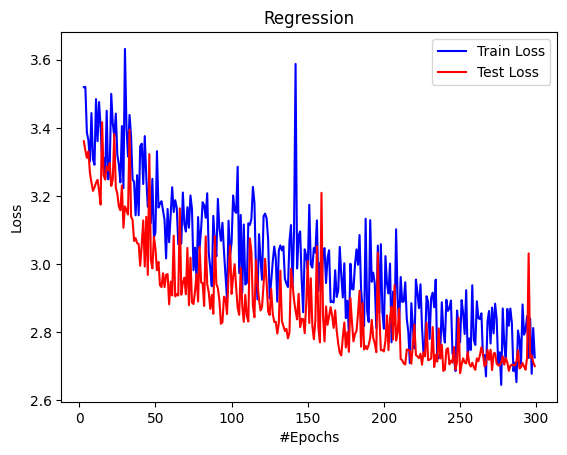

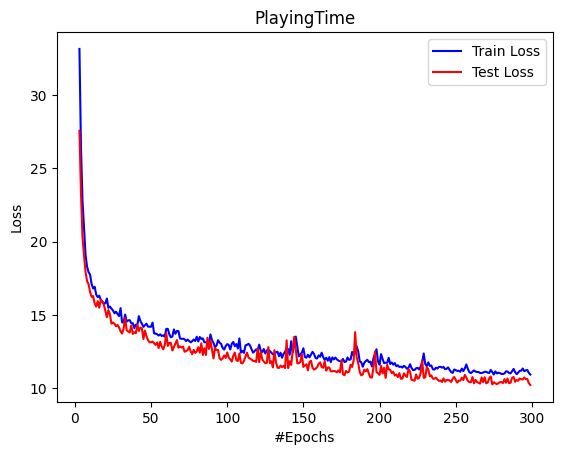

In [66]:
importlib.reload(Player_Model)
from Player_Model import RNN_Model
importlib.reload(Model_Train)
from Model_Train import trainAndGraph

hitting_mutators = data_prep.Generate_Hitting_Mutators(batch_size, Player_IO.GetMaxLength(hitter_io_list))

network = RNN_Model(train_dataset.get_input_size(), num_layers, hidden_size, hitting_mutators, data_prep=data_prep, is_hitter=True)
network = network.to(device)

best_losses = trainAndGraph(network, 
              train_dataset, 
              test_dataset,
              batch_size,
              num_epochs = num_epochs, 
              logging_interval=10, 
              early_stopping_cutoff=2000, 
              should_output=True, 
              model_name="Models/default_experimental_hitter", 
              save_last=True, 
              elements_to_save=[0])

print(best_losses)

Testing

In [ ]:
import torch
importlib.reload(Player_Model)
from Player_Model import Stats_Loss

hitlvlstat_means : torch.Tensor = getattr(data_prep, "__hitlvlstat_means").to(device)
hitlvlstat_devs : torch.Tensor = getattr(data_prep, "__hitlvlstat_devs").to(device)
hitpt_means : torch.Tensor = getattr(data_prep, "__hitlvlpt_means").to(device)
hitpt_devs : torch.Tensor = getattr(data_prep, "__hitlvlpt_devs").to(device)

torch.set_printoptions(precision=8, sci_mode=False)
torch.set_printoptions(
    precision=6,
    sci_mode=False,
    linewidth=500,
    edgeitems=6,
)

print_pa = True
print_stats = True
print_stats_level = 0

for hitter in hitter_io_list:
    if hitter.player.mlbId != 593934:# and hitter.player.mlbId != 596146:
        continue
    
    data = hitter.input.to(device)
    length = torch.tensor([hitter.length]).to(device)
    output_war, output_warregression, output_level, output_pa, output_yearStats, output_yearPos, output_mlbValue, output_pt = network(data.unsqueeze(0), length)
    
    dates = hitter.dates
    output_pt = output_pt.squeeze(0)
    output_yearStats = output_yearStats.squeeze(0)
    actual_pt = hitter.pt_year_output.squeeze(-1).to(device)
    
    actual_yearStats = hitter.year_stat_output.to(device)
    output_yearStats = output_yearStats.reshape(actual_yearStats.shape)
    
    loss = Stats_Loss(output_yearStats.unsqueeze(0), actual_yearStats.unsqueeze(0), hitter.year_level_mask.unsqueeze(0).to(device))
    for i in range(dates.size(0)):
        if i != 60:
            continue
        for j in range(8):
            output_pt[i,j] = (output_pt[i,j] * hitpt_devs) + hitpt_means
            actual_pt[i,j] = (actual_pt[i,j] * hitpt_devs) + hitpt_means
            output_yearStats[i,j] = (output_yearStats[i,j] * hitlvlstat_devs) + hitlvlstat_means
            actual_yearStats[i,j] = (actual_yearStats[i,j] * hitlvlstat_devs) + hitlvlstat_means
        
        print(f"Mask: {hitter.stat_level_mask[i,print_stats_level].item()}")
        if print_pa:
            print(f"Act:  {dates[i,1].item():4d}-{dates[i,2].item()} : MLB={actual_pt[i,0].item():3.0f},AAA={actual_pt[i,1].item():3.0f},AA={actual_pt[i,2].item():3.0f},A+={actual_pt[i,3].item():3.0f},A={actual_pt[i,4].item():3.0f},A-={actual_pt[i,5].item():3.0f},Rk={actual_pt[i,6].item():3.0f},DSL={actual_pt[i,7].item():3.0f}")
            print(f"Pred: {dates[i,1].item():4d}-{dates[i,2].item()} : MLB={output_pt[i,0].item():3.0f},AAA={output_pt[i,1].item():3.0f},AA={output_pt[i,2].item():3.0f},A+={output_pt[i,3].item():3.0f},A={output_pt[i,4].item():3.0f},A-={output_pt[i,5].item():3.0f},Rk={output_pt[i,6].item():3.0f},DSL={output_pt[i,7].item():3.0f}\n")
            
        if print_stats:
            a = actual_yearStats[i,print_stats_level]
            p = output_yearStats[i,print_stats_level]
            print(f"Act:  {dates[i,1].item():4d}-{dates[i,2].item()} : 1B={a[0].item():2.2f},2B={a[1].item():2.2f},3B={a[2].item():2.2f},HR={a[3].item():2.2f},BB={a[4].item():2.2f},HBP={a[5].item():2.2f},K={a[6].item():2.2f},SB={a[7].item():2.2f},CS={a[8].item():2.2f},PF={a[9].item():2.2f}")
            print(f"Pred: {dates[i,1].item():4d}-{dates[i,2].item()} : 1B={p[0].item():2.2f},2B={p[1].item():2.2f},3B={p[2].item():2.2f},HR={p[3].item():2.2f},BB={p[4].item():2.2f},HBP={p[5].item():2.2f},K={p[6].item():2.2f},SB={p[7].item():2.2f},CS={p[8].item():2.2f},PF={p[9].item():2.2f}\n")
    

Mask: 0.0
Act:     0-0 : MLB=  0,AAA=  0,AA=  0,A+=  0,A=  0,A-=  0,Rk=  0,DSL=  0
Pred:    0-0 : MLB=  0,AAA=  0,AA=  0,A+=  0,A=  0,A-=  0,Rk=  1,DSL=  2

Act:     0-0 : 1B=0.95,2B=0.87,3B=0.60,HR=0.72,BB=0.92,HBP=0.75,K=0.99,SB=0.70,CS=0.67,PF=0.99
Pred:    0-0 : 1B=1.00,2B=0.96,3B=0.88,HR=0.68,BB=0.79,HBP=0.04,K=0.98,SB=0.40,CS=0.49,PF=1.00

Mask: 0.0
Act:  2010-5 : MLB=  0,AAA=  0,AA=  0,A+=  0,A=  0,A-=  0,Rk=161,DSL= 76
Pred: 2010-5 : MLB=  0,AAA=  0,AA=  0,A+=  0,A=  3,A-=  2,Rk= 14,DSL=158

Act:  2010-5 : 1B=0.95,2B=0.87,3B=0.60,HR=0.72,BB=0.92,HBP=0.75,K=0.99,SB=0.70,CS=0.67,PF=0.99
Pred: 2010-5 : 1B=1.02,2B=0.88,3B=1.23,HR=0.74,BB=0.74,HBP=0.31,K=1.00,SB=0.38,CS=0.56,PF=1.02

Mask: 0.0
Act:  2010-6 : MLB=  0,AAA=  0,AA=  0,A+=  0,A=  0,A-=  0,Rk=207,DSL=  9
Pred: 2010-6 : MLB=  0,AAA=  0,AA=  0,A+=  0,A= 11,A-=  5,Rk= 36,DSL=123

Act:  2010-6 : 1B=0.95,2B=0.87,3B=0.60,HR=0.72,BB=0.92,HBP=0.75,K=0.99,SB=0.70,CS=0.67,PF=0.99
Pred: 2010-6 : 1B=0.99,2B=0.90,3B=0.92,HR=0.67,BB=0.

Base Pretraining

In [ ]:
num_layers = DEFAULT_NUM_LAYERS_HITTER
hidden_size = DEFAULT_HIDDEN_SIZE_HITTER

In [ ]:
data_prep = Data_Prep(Prep_Map.base_prep_map, Output_Map.base_output_map)
hitter_io_list = data_prep.Generate_IO_Hitters("WHERE lastMLBSeason<? AND signingYear<? AND isHitter=?", (2025,2015,1), use_cutoff=True)
train_dataset, test_dataset = Create_Test_Train_Datasets(hitter_io_list, 0.25, 0)

In [ ]:
hitting_mutators = data_prep.Generate_Hitting_Mutators(batch_size, Player_IO.GetMaxLength(hitter_io_list))

network = RNN_Model(train_dataset.get_input_size(), num_layers, hidden_size, hitting_mutators, data_prep=data_prep, is_hitter=True)
network = network.to(device)

best_losses = trainAndGraph(network, 
              train_dataset, 
              test_dataset,
              batch_size,
              num_epochs=num_epochs, 
              logging_interval=10, 
              early_stopping_cutoff=2000, 
              should_output=True, 
              model_name="Models/default_hitter", 
              save_last=True,
              elements_to_save=[0])
print(best_losses)

Statsonly pretraining

In [ ]:
data_prep = Data_Prep(Prep_Map.statsonly_prep_map, Output_Map.base_output_map)
hitter_io_list = data_prep.Generate_IO_Hitters("WHERE lastMLBSeason<? AND signingYear<? AND isHitter=?", (2025,2015,1), use_cutoff=True)
train_dataset, test_dataset = Create_Test_Train_Datasets(hitter_io_list, 0.25, 0)

In [ ]:
hitting_mutators = data_prep.Generate_Hitting_Mutators(batch_size, Player_IO.GetMaxLength(hitter_io_list))

network = RNN_Model(train_dataset.get_input_size(), num_layers, hidden_size, hitting_mutators, data_prep=data_prep, is_hitter=True)
network = network.to(device)

best_losses = trainAndGraph(network, 
              train_dataset, 
              test_dataset,
              batch_size,
              num_epochs=num_epochs, 
              logging_interval=10, 
              early_stopping_cutoff=2000, 
              should_output=True, 
              model_name="Models/default_statsonly_hitter", 
              save_last=True, 
              elements_to_save=[0])

print(best_losses)